# Тестовое задание на должность младшего аналитика в компанию, разрабатывающую дейтинговые приложения.
В предоставленном для исследования файле представлены данные по работе рекламных кампаний, запущенных пятью медиабайерами для привлечения пользователей в приложение. 
Имеющиеся поля:
* Campaign_id - ID кампании;
* Geo - геопозиция, на которую настроена рекламная кампания;
* Buyer - байер, выполнивший запуск;
* Impressions - количество показов рекламных объявлений;
* Clicks - количество кликов; 
* Installs - количество установок;
* Registrations - количество регистраций;
* Spend - Затраченная сумма;
* Revenue_ad (1d/7d/30d) - Выручка с рекламы от пользователей, зарегистрировавшихся в приложении, на 1/7/30 день их жизни
* Revenue_in_app (1d/7d/30d) - Выручка с покупок от пользователей, зарегистрировавшихся в приложении, на 1/7/30 день их жизни
* Payers (1d/7d/30d) - Количество покупателей в приложении на 1/7/30 день их жизни
Необходимо исследовать данные и получить выводы, которые могут помочь дальнейшей работе медиабайера. 
Например: кампании в каких гео показали себя хуже всего? Кто из медиабайеров лучше всего окупается? У каких компаний дешевле установки? Необходимо сформулировать как можно больше вопросов и провести наиболее полный анализ. 

## Шаг 1. Подготовка и предобработка.

Для начала импортирую необходимые библиотеки. 

In [12]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns

In [13]:
data = pd.read_csv('/datasets/test_data.csv')
data.head()

,Campaign_id,Geo,Buyer,Impressions,Clicks,Installs,Registrations,Spend,Revenue_ad1d,Revenue_in_app1d,Payers1d,Revenue_ad7d,Revenue_in_app7d,Payers7d,Revenue_ad30d,Revenue_in_app30d,Payers30d
0,1,north america,buyer_1,3456974,129508,33054,21932,"3208,440002","1163,521408","162,220001",64,"1381,310062","199,749999",79,"1527,013835","276,629998",83
1,2,north america,buyer_2,245542,6306,3401,2448,"1569,519999","833,059639","37,25",17,"1200,964697","69,340001",19,"1449,001828","120,250001",22
2,3,north america,buyer_1,1281103,35724,13315,8101,"1231,999998","459,6826","3,26",4,"524,987826","24,7",6,"572,633765","24,7",6
3,4,north america,buyer_1,215538,9987,3119,1857,"1228,129999","602,77816","26,13",11,"830,113889","33,439999",12,"1042,831595","57,530002",12
4,5,western europe,buyer_2,335878,7343,3952,2955,"872,570005","427,807238","19,030001",4,"577,039081","20,640001",5,"714,554179","32,150001",6


Датасет нормально импортировался, теперь нужно привести его к удобному для обработки и исследованию формату и проверить на наличие пропусков и дубликатов. Для этого использую функцию для предобработки, написанную мной ранее.

In [14]:
def fix_and_check (dataset):
    dataset.columns = [x.lower().replace(' ', '_') for x in dataset.columns]
    dataset.columns
    print('Пропуски: ')
    print(dataset.isna().sum())
    print('*'*50)
    print('Дубликаты: ')
    print(dataset.duplicated().sum())
    print('*'*50)
    print('Типы данных: ')
    print(dataset.dtypes)
    return dataset

In [15]:
data = fix_and_check(data)

Пропуски: 
campaign_id          0
geo                  0
buyer                0
impressions          0
clicks               0
installs             0
registrations        0
spend                0
revenue_ad1d         0
revenue_in_app1d     0
payers1d             0
revenue_ad7d         0
revenue_in_app7d     0
payers7d             0
revenue_ad30d        0
revenue_in_app30d    0
payers30d            0
dtype: int64
**************************************************
Дубликаты: 
0
**************************************************
Типы данных: 
campaign_id           int64
geo                  object
buyer                object
impressions           int64
clicks                int64
installs              int64
registrations         int64
spend                object
revenue_ad1d         object
revenue_in_app1d     object
payers1d              int64
revenue_ad7d         object
revenue_in_app7d     object
payers7d              int64
revenue_ad30d        object
revenue_in_app30d    object
payers3

Теперь названия столбцов в датасете приведены к camel_case, и проверка показала, что в данных нет пропусков и дубликатов. Но в некоторых столбцах типы данных не соответствуют нужным - столбцы spend, revenue_ad имеют типы object, но они хранят числовые значения, поэтому нужно привести их к типу данных float. 

In [16]:
def str_to_float(data, cols):
    for column in cols:
        data[column] = data[column].str.replace(',', '.').replace(' ', '').astype(float)
    return data

In [17]:
cols = ['spend', 'revenue_ad1d', 'revenue_in_app1d', 'revenue_ad7d', 'revenue_in_app7d', 'revenue_ad30d', 'revenue_in_app30d']
data = str_to_float(data, cols=cols)

Проверим, все ли изменения вступили в силу:

In [21]:
data.dtypes

campaign_id            int64
geo                   object
buyer                 object
impressions            int64
clicks                 int64
installs               int64
registrations          int64
spend                float64
revenue_ad1d         float64
revenue_in_app1d     float64
payers1d               int64
revenue_ad7d         float64
revenue_in_app7d     float64
payers7d               int64
revenue_ad30d        float64
revenue_in_app30d    float64
payers30d              int64
dtype: object

In [22]:
data.head()

,campaign_id,geo,buyer,impressions,clicks,installs,registrations,spend,revenue_ad1d,revenue_in_app1d,payers1d,revenue_ad7d,revenue_in_app7d,payers7d,revenue_ad30d,revenue_in_app30d,payers30d
0,1,north america,buyer_1,3456974,129508,33054,21932,3208.440002,1163.521408,162.220001,64,1381.310062,199.749999,79,1527.013835,276.629998,83
1,2,north america,buyer_2,245542,6306,3401,2448,1569.519999,833.059639,37.250000,17,1200.964697,69.340001,19,1449.001828,120.250001,22
2,3,north america,buyer_1,1281103,35724,13315,8101,1231.999998,459.682600,3.260000,4,524.987826,24.700000,6,572.633765,24.700000,6
3,4,north america,buyer_1,215538,9987,3119,1857,1228.129999,602.778160,26.130000,11,830.113889,33.439999,12,1042.831595,57.530002,12
4,5,western europe,buyer_2,335878,7343,3952,2955,872.570005,427.807238,19.030001,4,577.039081,20.640001,5,714.554179,32.150001,6


Сделаем общую диаграмму для всех столбцов таблицы. 

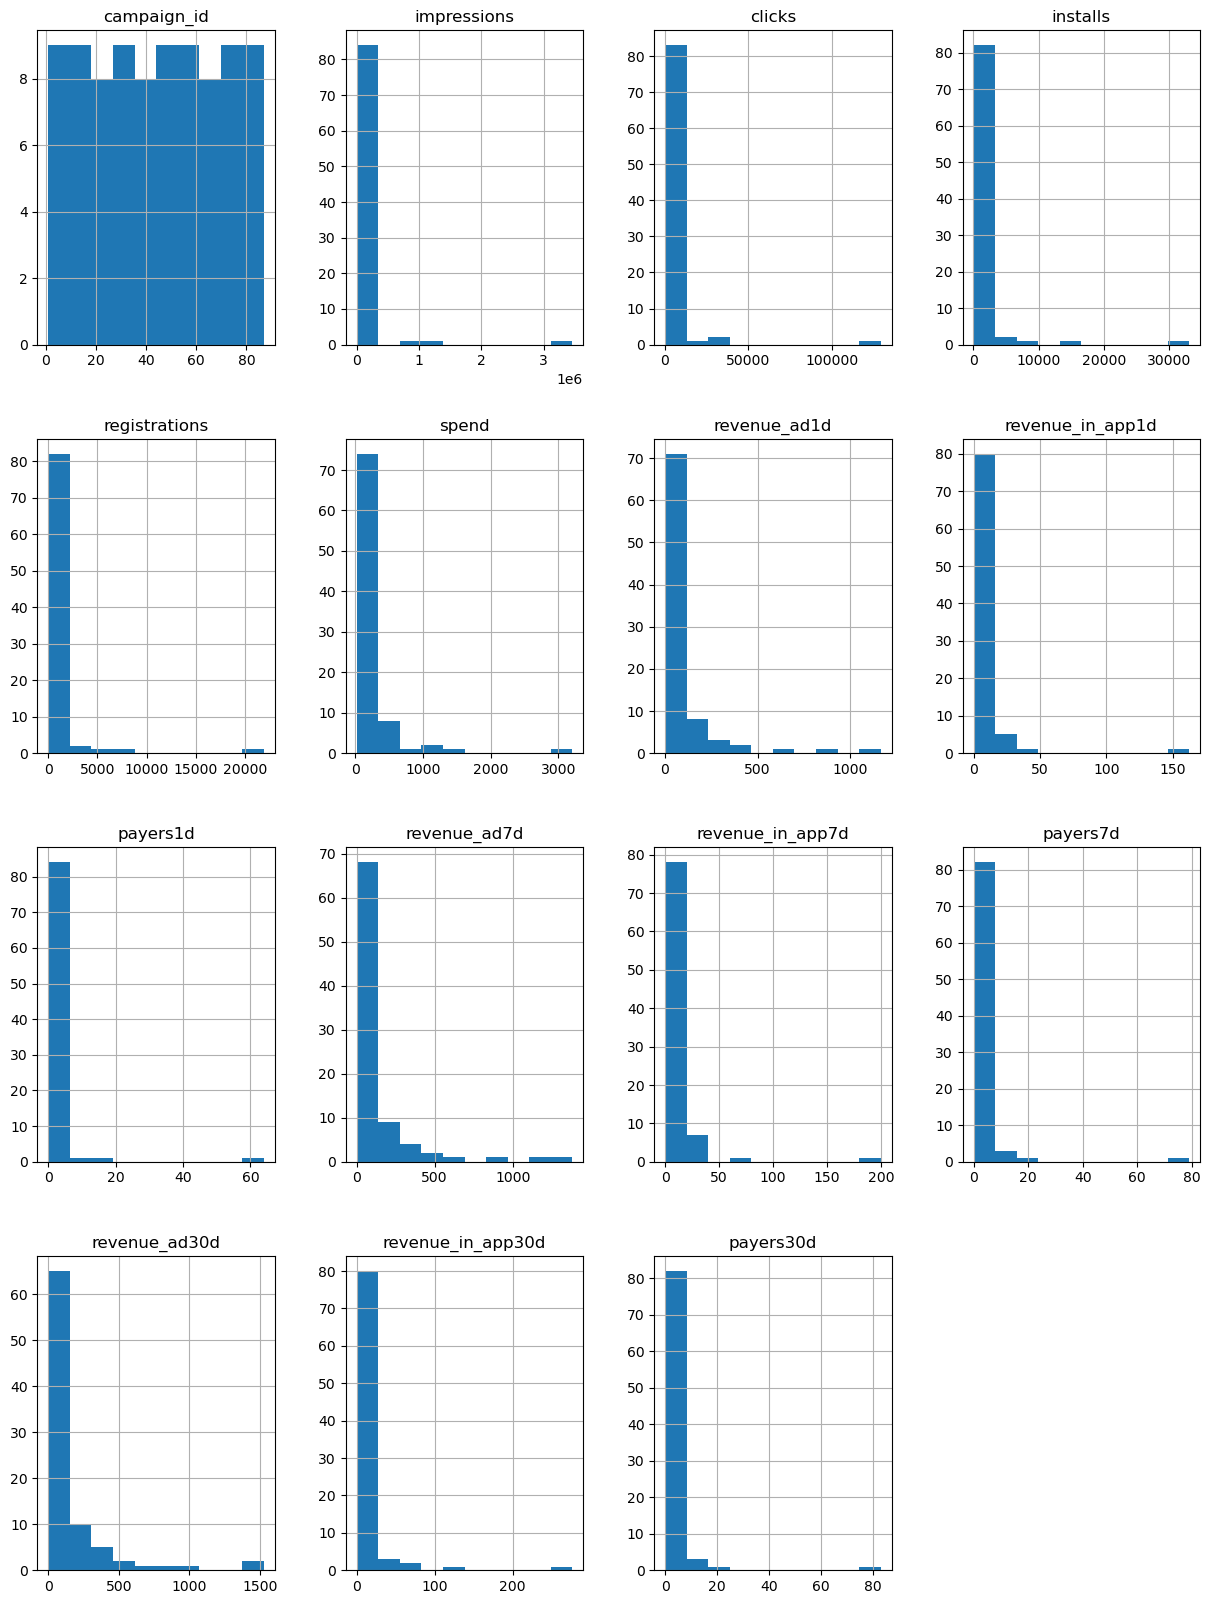

In [23]:
data.hist(figsize=(15, 20));

## Шаг 2. Дополнение данных необходимыми показателями

Для поиска нужных ответов я добавлю столбцы CR, CTR, CPI и ARPU чтобы изучить эффективность рекламных кампаний на этих показателях.  
- CR - конверсия, отношение количества кликов по рекламе к реакциям на неё.
- CTR - кликабельность, отношение кликов к регистрации.
- CPI - отношение стоимости размещения рекламы к количеству установок. Чем оно ниже, тем лучше.
- CPC - цена за один клик по рекламе
- ARPU - средний доход от одного пользователя 

In [24]:
data['ctr, %'] = round((data['clicks'] / data['impressions'] * 100), 2)

In [25]:
data['cr, %'] = round((data['registrations'] / data['clicks'] * 100), 2)

In [26]:
data['cpi'] = round((data['spend'] / data['installs']), 2)

In [27]:
data['cpc'] = round((data['spend'] / data['clicks']), 2)

In [28]:
data['arpu1d'] = round((data['revenue_in_app1d'] / data['payers1d']), 2)
data['arpu7d'] = round((data['revenue_in_app7d'] / data['payers7d']), 2)
data['arpu30d'] = round((data['revenue_in_app30d'] / data['payers30d']), 2)

In [29]:
data.head()

,campaign_id,geo,buyer,impressions,clicks,installs,registrations,spend,revenue_ad1d,revenue_in_app1d,...,revenue_ad30d,revenue_in_app30d,payers30d,"ctr, %","cr, %",cpi,cpc,arpu1d,arpu7d,arpu30d
0,1,north america,buyer_1,3456974,129508,33054,21932,3208.440002,1163.521408,162.220001,...,1527.013835,276.629998,83,3.75,16.93,0.10,0.02,2.53,2.53,3.33
1,2,north america,buyer_2,245542,6306,3401,2448,1569.519999,833.059639,37.250000,...,1449.001828,120.250001,22,2.57,38.82,0.46,0.25,2.19,3.65,5.47
2,3,north america,buyer_1,1281103,35724,13315,8101,1231.999998,459.682600,3.260000,...,572.633765,24.700000,6,2.79,22.68,0.09,0.03,0.82,4.12,4.12
3,4,north america,buyer_1,215538,9987,3119,1857,1228.129999,602.778160,26.130000,...,1042.831595,57.530002,12,4.63,18.59,0.39,0.12,2.38,2.79,4.79
4,5,western europe,buyer_2,335878,7343,3952,2955,872.570005,427.807238,19.030001,...,714.554179,32.150001,6,2.19,40.24,0.22,0.12,4.76,4.13,5.36


Теперь к столбцам датасета добавлены показатели, благодаря которым эффективность кампаний можно будет оценить в числах.

## Шаг 3. Оценка эффективности медиабайеров

In [30]:
data_buyers = data.groupby('buyer')['buyer'].count().sort_values(ascending=False)

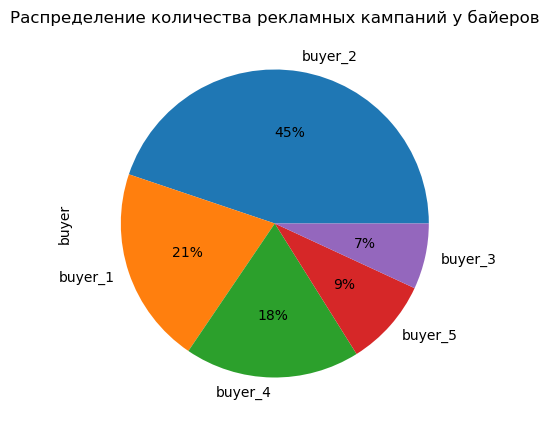

In [31]:
data_buyers.plot(kind='pie', y='buyer', legend=False, figsize=(12,5), autopct='%.0f%%')
plt.title('Распределение количества рекламных кампаний у байеров');

По количеству рекламных кампаний лидирует второй байер - у него 45% от всех рекламных кампаний. 21% от всего числа рекламных кампаний имеет первый байер, на третьем четвёртый.

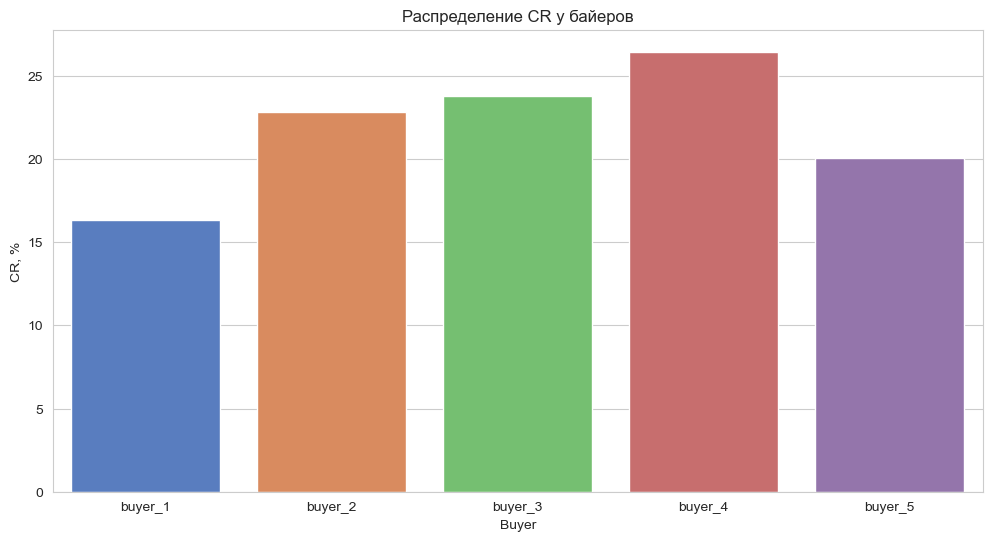

In [96]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

sns.barplot(x='buyer', y='cr, %', data=data, ci=None, palette="muted")
plt.title('Распределение CR у байеров')
plt.xlabel('Buyer')
plt.ylabel('CR, %')
plt.show()

plt.show()

В конверсии лучший байер - четвёртый. У него самый высокий показатель. 

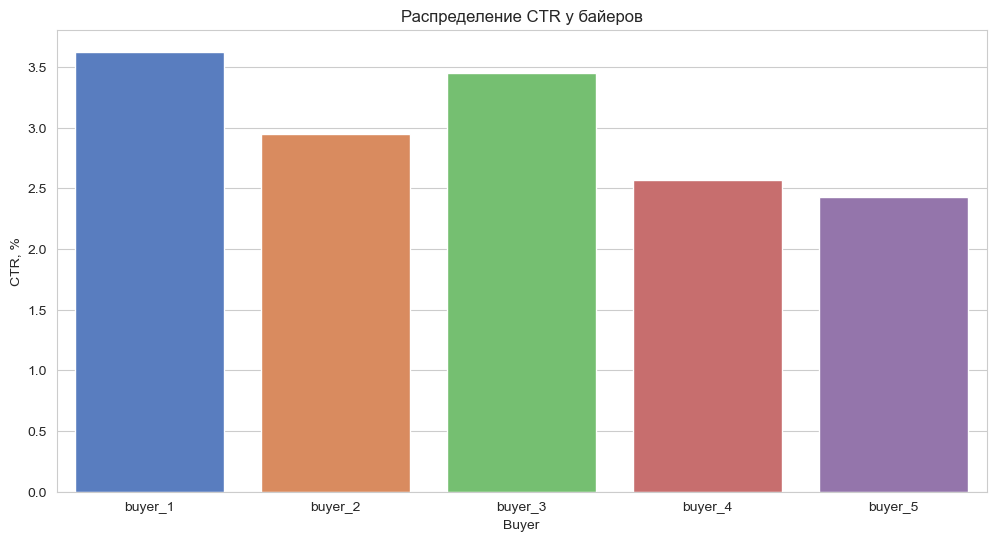

In [95]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

sns.barplot(x='buyer', y='ctr, %', data=data, ci=None, palette="muted")
plt.title('Распределение CTR у байеров')
plt.xlabel('Buyer')
plt.ylabel('CTR, %')
plt.show()

plt.show()

По конверсии из клика в регистрацию на первом месте первый байер.

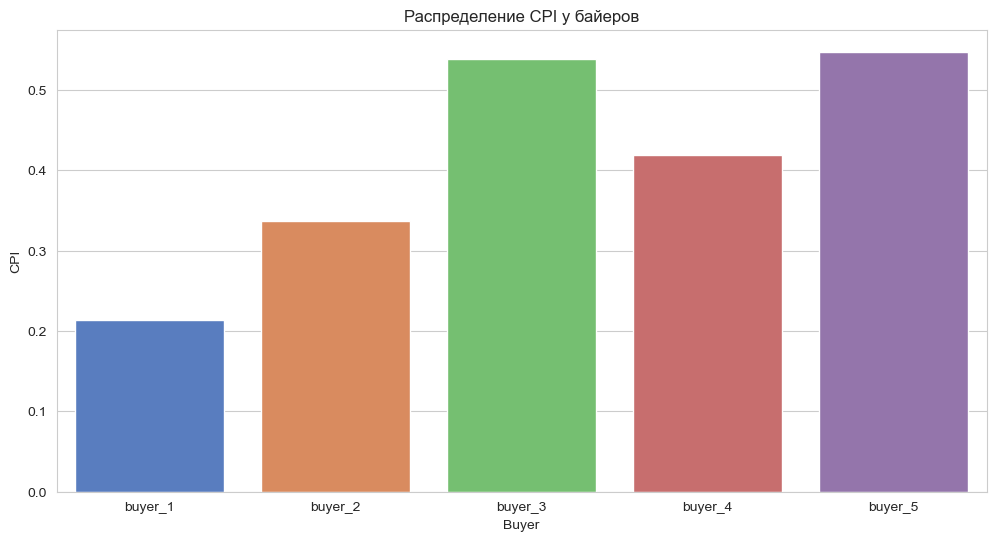

In [94]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

sns.barplot(x='buyer', y='cpi', data=data, ci=None, palette="muted")
plt.title('Распределение CPI у байеров')
plt.xlabel('Buyer')
plt.ylabel('CPI')
plt.show()

plt.show()

Чем CPI - цена установки - ниже, тем лучше. У первого байера она самая низкая - это лучший результат.

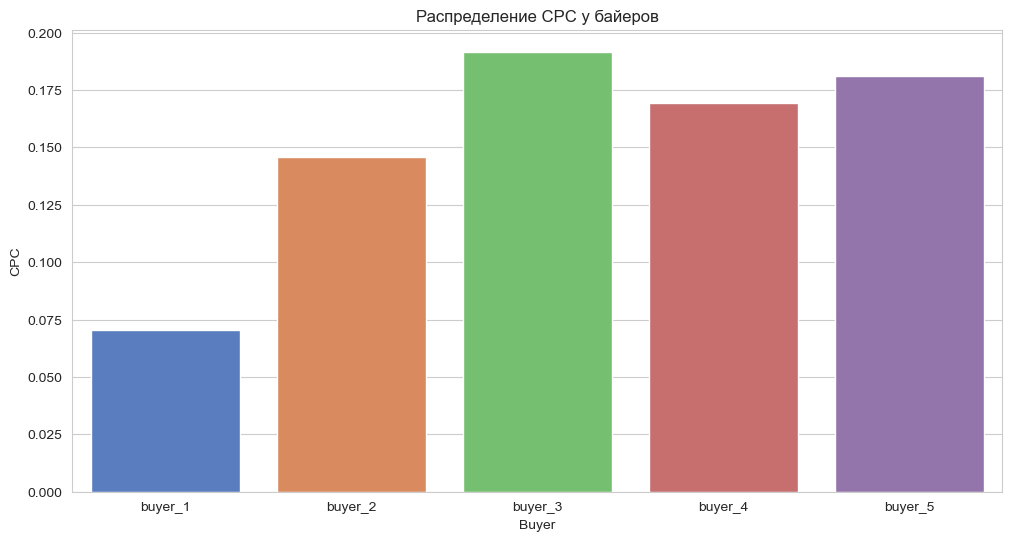

In [93]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

sns.barplot(x='buyer', y='cpc', data=data, ci=None, palette="muted")
plt.title('Распределение CPC у байеров')
plt.xlabel('Buyer')
plt.ylabel('CPC')
plt.show()

plt.show()

CPC - цена за клик, у первого байера тоже самая низкая.

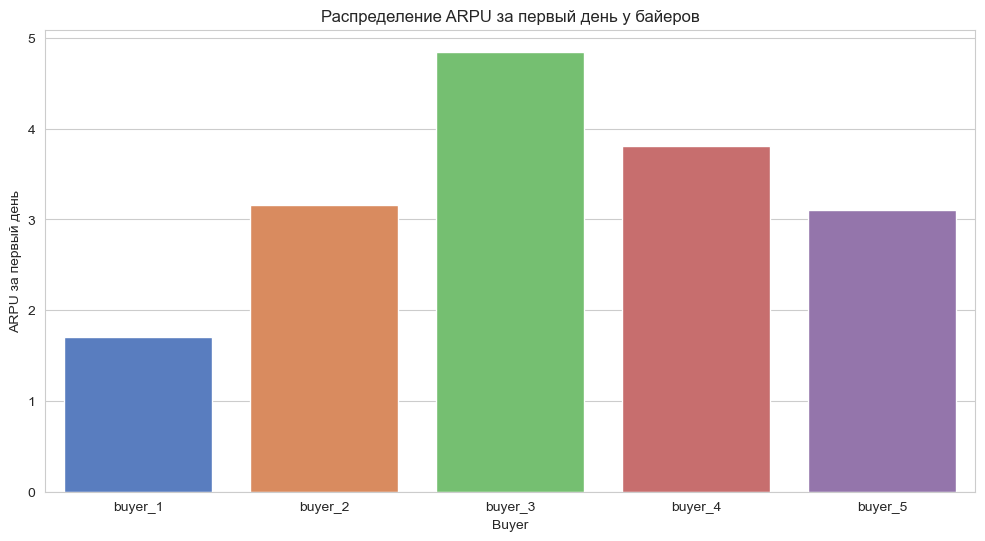

In [92]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

sns.barplot(x='buyer', y='arpu1d', data=data, ci=None, palette="muted")
plt.title('Распределение ARPU за первый день у байеров')
plt.xlabel('Buyer')
plt.ylabel('ARPU за первый день')
plt.show()

plt.show()

В первый день наиболее доходные пользователи приходят от третьего байера. Лидер предыдущих измерений, первый байер, по этому параметру наименее эффективен. 

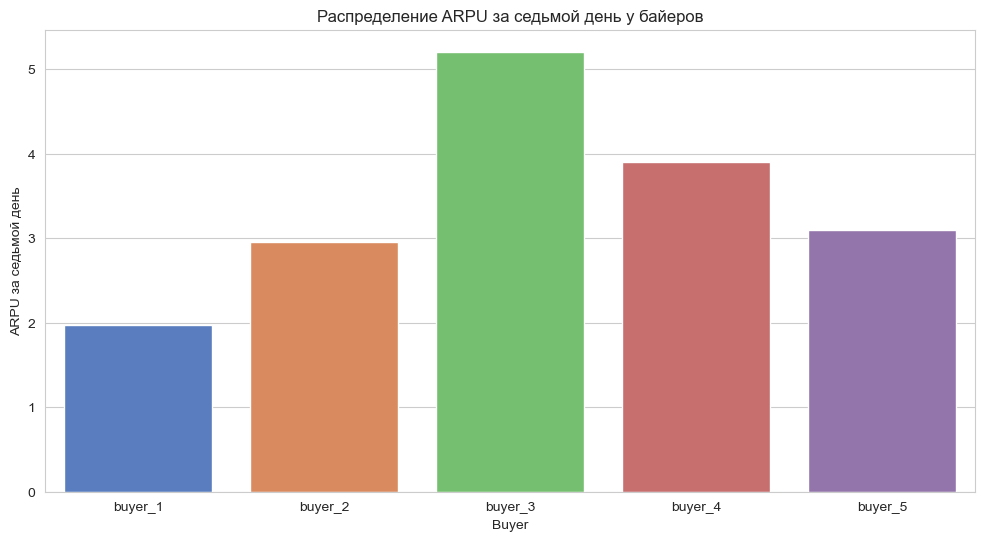

In [91]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

sns.barplot(x='buyer', y='arpu7d', data=data, ci=None, palette="muted")
plt.title('Распределение ARPU за седьмой день у байеров')
plt.xlabel('Buyer')
plt.ylabel('ARPU за седьмой день')
plt.show()

plt.show()

На седьмой день положение практически не меняется. 

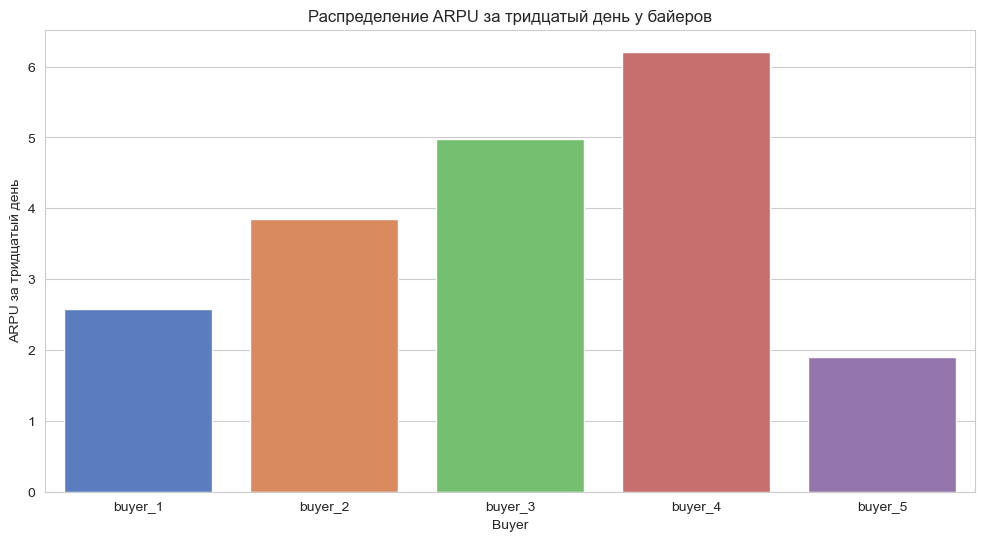

In [90]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

sns.barplot(x='buyer', y='arpu30d', data=data, ci=None, palette="muted")
plt.title('Распределение ARPU за тридцатый день у байеров')
plt.xlabel('Buyer')
plt.ylabel('ARPU за тридцатый день')
plt.show()

plt.show()

На тридцатый день ARPU значительно снижается у пятого байера, и сильно возрастает у четвёртого - теперь он на первом месте. 

In [75]:
data_buyers_spend = data.groupby('buyer')['spend'].sum().sort_values(ascending=False)

Text(0.5, 1.0, 'Распределение рекламного бюджета между байерами')

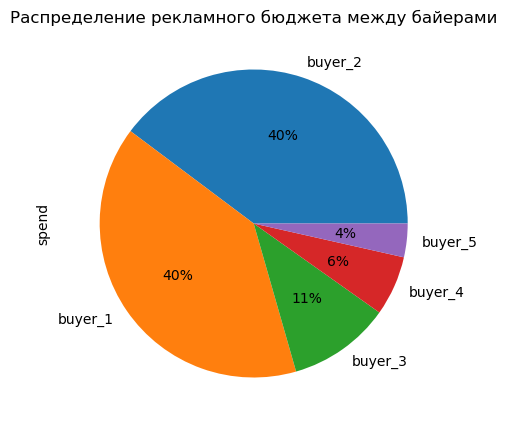

In [40]:
data_buyers_spend.plot(kind='pie', y='buyer', legend=False, figsize=(12,5), autopct='%.0f%%')
plt.title('Распределение рекламного бюджета между байерами')

По 40% от бюджета делят между собой первый и второй байеры. У третьего байера всего 11 процентов, у четвёртого 6%, у пятого 4%.

### Промежуточный вывод
Медиабайер под номером один имеет наибольшую эффективность по всем параметрам, кроме конверсии реакций в клики - по этому параметру он на последнем месте. В остальном у него лучшие результаты. При этом расходы на его кампании равны расходам на рекламные кампании у второго байера, который имеет достаточно средние показатели. Также достаточно хорошие показатели у третьего байера, но высокая цена и за клик, и за регистрацию. 

Прибыль с одного пользователя в первый день и седьмой выше всего у третьего байера, а на тридцатый - у четвёртого. 

## Шаг 4. Оценка влияния гео на эффективность кампаний

In [41]:
data_geo = data.groupby('geo')['geo'].count().sort_values(ascending=False)

Text(0.5, 1.0, 'Распределение количества рекламных кампаний по гео')

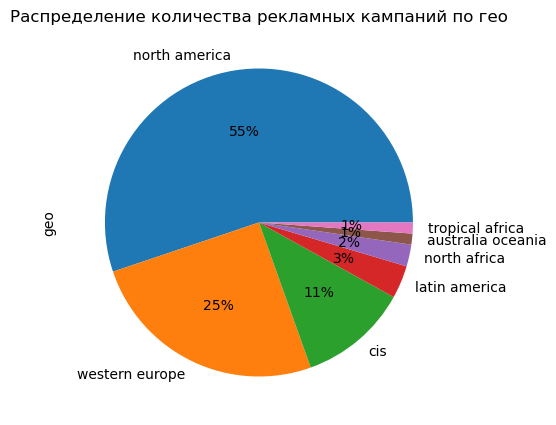

In [42]:
data_geo.plot(kind='pie', y='geo', legend=False, figsize=(12,5), autopct='%.0f%%')
plt.title('Распределение количества рекламных кампаний по гео')

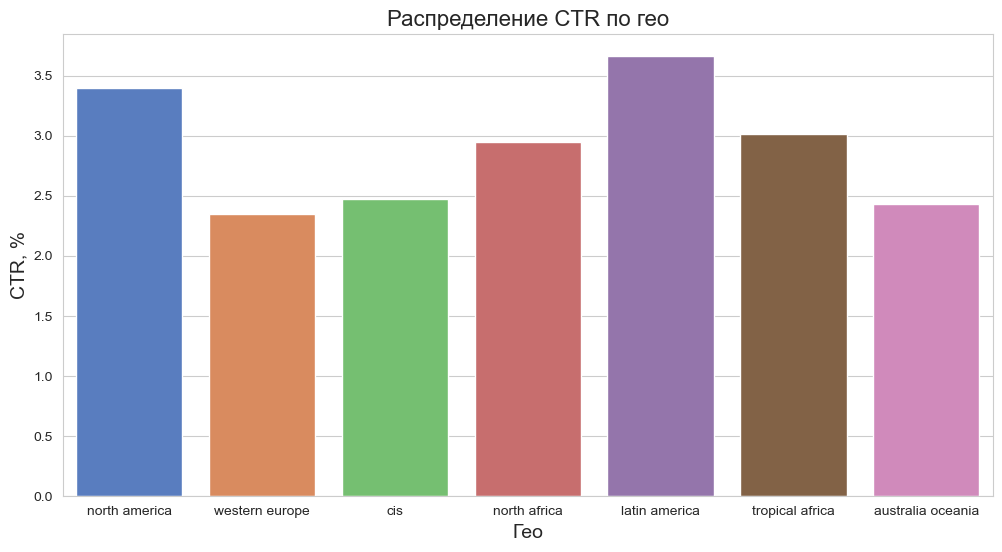

In [86]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

sns.barplot(x='geo', y='ctr, %', data=data, ci=None, palette="muted")
plt.title('Распределение CTR по гео', fontsize=16)
plt.xlabel('Гео', fontsize=14)
plt.ylabel('CTR, %', fontsize=14)

plt.show()

55% от всех рекламных кампаний проводится в Северной Америке. 25% приходится на Восточную Европу, и 11% на страны СНГ. 

Text(0, 0.5, 'CR, %')

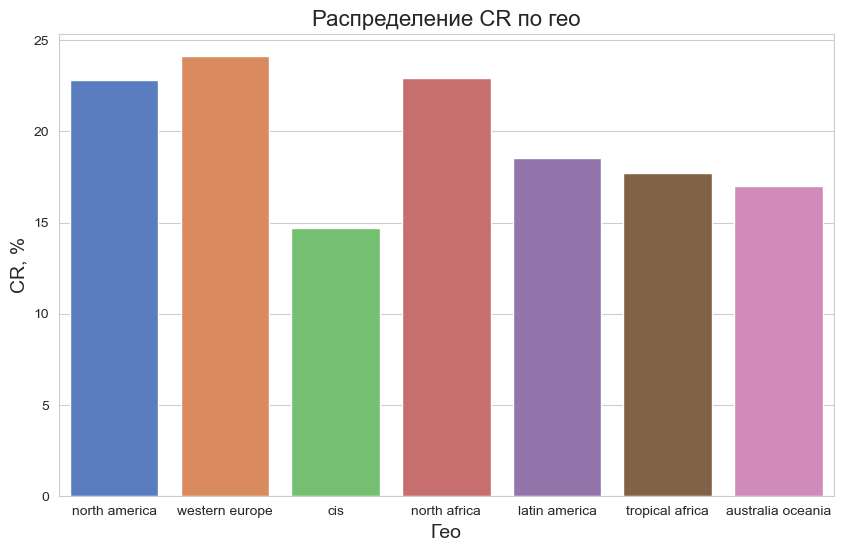

In [84]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

sns.barplot(x='geo', y='cr, %', data=data, ci=None, palette="muted")
plt.title('Распределение CR по гео', fontsize=16)
plt.xlabel('Гео', fontsize=14)
plt.ylabel('CR, %', fontsize=14)

Лучше всего конвертируются пользователи из Восточной Европы. На втором месте Северная Америка и Северная Африка.

Text(0, 0.5, 'CTR, %')

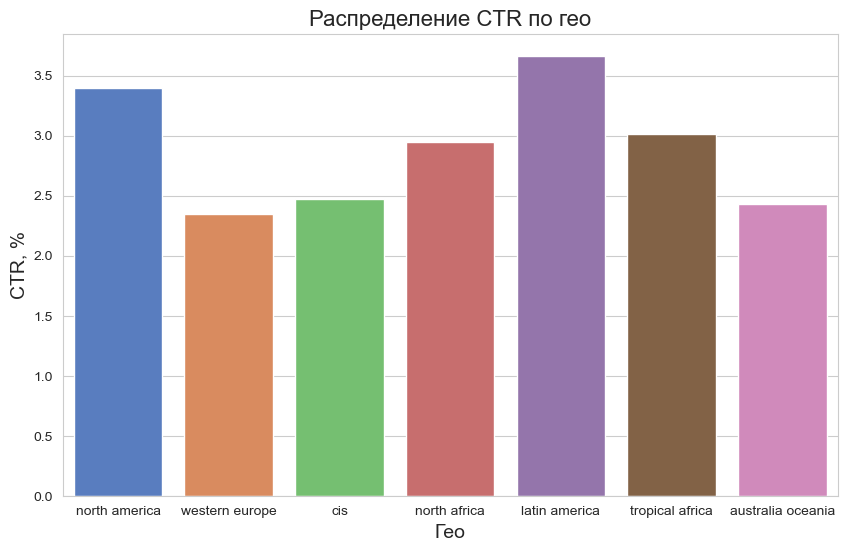

In [83]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

sns.barplot(x='geo', y='ctr, %', data=data, ci=None, palette="muted")
plt.title('Распределение CTR по гео', fontsize=16)
plt.xlabel('Гео', fontsize=14)
plt.ylabel('CTR, %', fontsize=14)

Конверсии в регистрацию выше всего в Латинской Америке. На втором месте Северная Америка. 

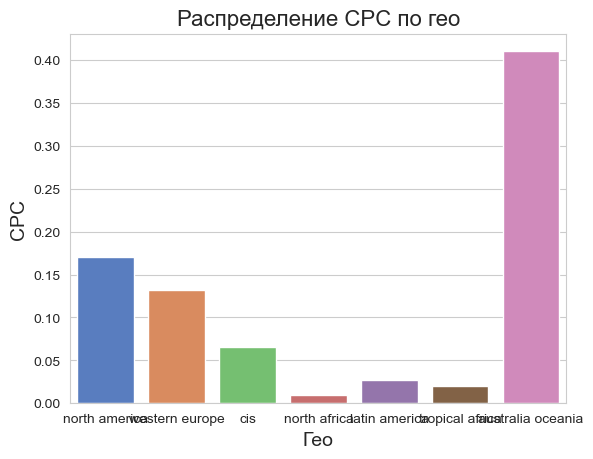

In [82]:
sns.barplot(x='geo', y='cpc', data=data, ci=None, palette="muted")
plt.title('Распределение CPC по гео', fontsize=16)
plt.xlabel('Гео', fontsize=14)
plt.ylabel('CPC', fontsize=14)

plt.show()

Дешевле всего обходится установка в Северной и Тропической Африке. В Австралии и Океании огромная цена за одну установку.

Text(0, 0.5, 'CPC')

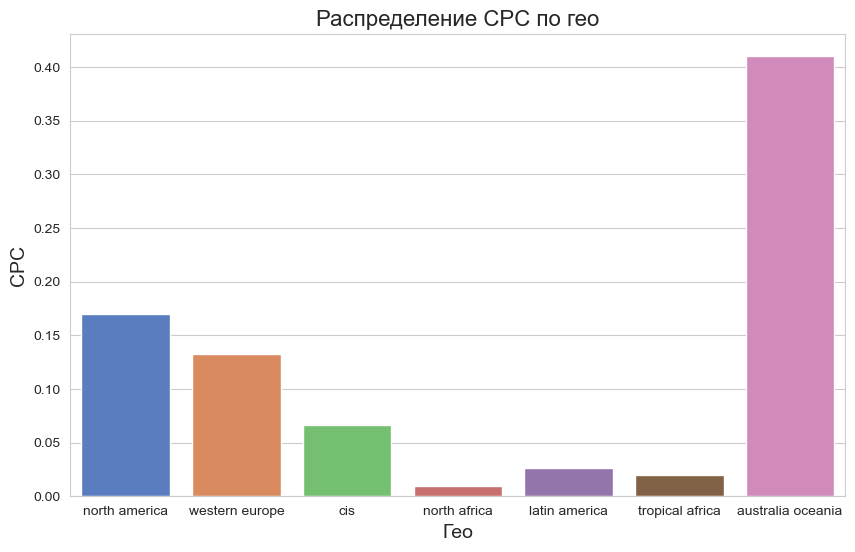

In [81]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

sns.barplot(x='geo', y='cpc', data=data, ci=None, palette="muted")
plt.title('Распределение CPC по гео', fontsize=16)
plt.xlabel('Гео', fontsize=14)
plt.ylabel('CPC', fontsize=14)

Цена за клик также очень низкая в Северной Африке и очень высокая в Австралии и Океании. 

Text(0, 0.5, 'ARPU за первый день')

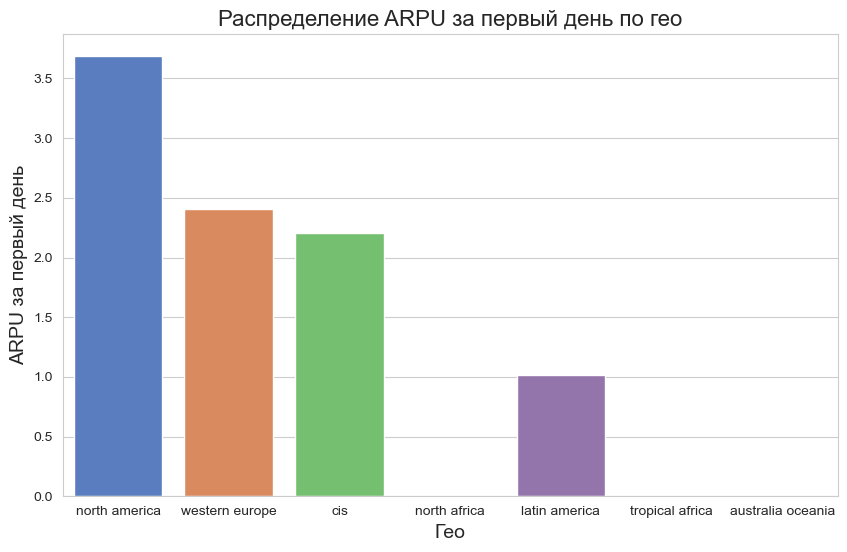

In [80]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

sns.barplot(x='geo', y='arpu1d', data=data, ci=None, palette="muted")
plt.title('Распределение ARPU за первый день по гео', fontsize=16)
plt.xlabel('Гео', fontsize=14)
plt.ylabel('ARPU за первый день', fontsize=14)

Средняя ценность пользователя в первый день выше всего в Северной Америке.

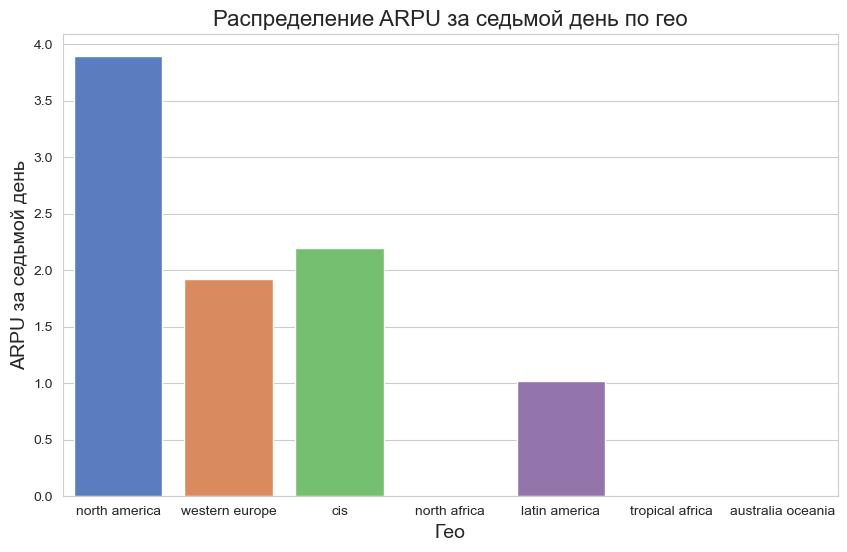

In [100]:
sns.set_style("whitegrid") 
plt.figure(figsize=(10, 6)) 

sns.barplot(x='geo', y='arpu7d', data=data, ci=None, palette="muted")
plt.title('Распределение ARPU за седьмой день по гео', fontsize=16) 
plt.xlabel('Гео', fontsize=14)
plt.ylabel('ARPU за седьмой день', fontsize=14)

plt.show()

На седьмой день также наиболее платящие пользователи приходят из Северной Америки.

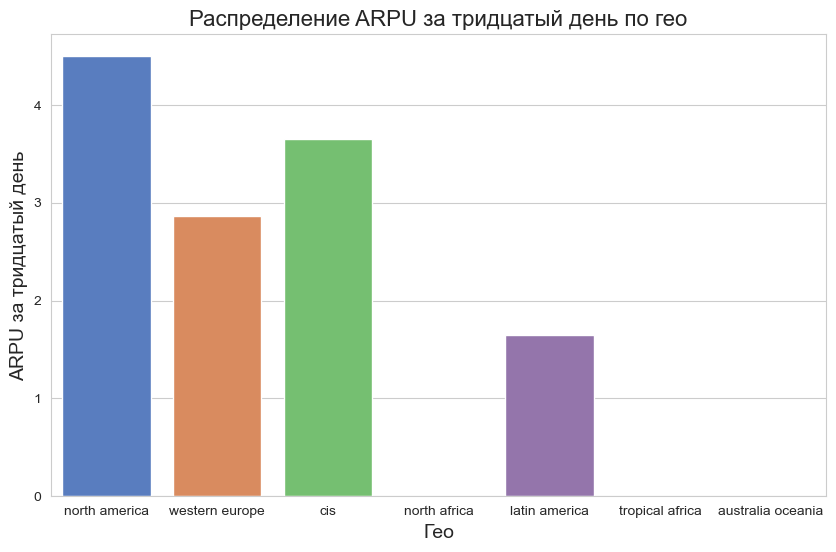

In [98]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

sns.barplot(x='geo', y='arpu30d', data=data, ci=None, palette="muted")
plt.title('Распределение ARPU за тридцатый день по гео', fontsize=16)
plt.xlabel('Гео', fontsize=14)
plt.ylabel('ARPU за тридцатый день', fontsize=14)

plt.show()

И на тридцатый день лидирует также Северная Америка. 

In [50]:
data_geo_spend = data.groupby('geo')['spend'].sum().sort_values(ascending=False)

Text(0.5, 1.0, 'Распределение рекламного бюджета между гео')

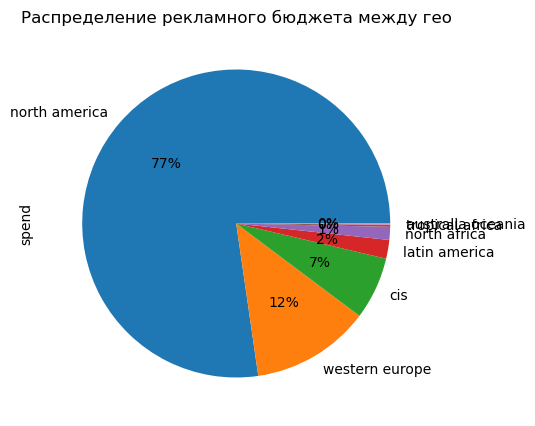

In [51]:
data_geo_spend.plot(kind='pie', y='geo', legend=False, figsize=(12,5), autopct='%.0f%%')
plt.title('Распределение рекламного бюджета между гео')

77% от всего рекламного бюджета уходит в Северную Америку. На втором месте Восточная Европа.

### Промежуточный вывод
В распределении по геопозиции установлено, что лучше всего конвертируются пользователи из Восточной Европы, регистрируются после клика - пользователи из Латинской Америки и Северной Америки, а дешевле всего клик и установка обходятся для пользователей из Северной Африки.  

Средний доход от одного пользователя выше всего и в первый, и в седьмой, и в тридцатый день выше всего в Северной Америке. 

## Шаг 5. Статистический анализ данных. Проверка гипотез.

Проверим гипотезу: одинаковы ли средние расходы на рекламную кампанию для первого и второго байера? 

Нулевая гипотеза: средние расходы на рекламную кампанию для первого и второго байера одинаковы.

Альтернативная гипотеза: средние расходы на рекламную кампанию для первого и второго байера различаются. 

In [52]:
from scipy import stats as st

In [54]:
buyer_1 = data.loc[data['buyer'] == 'buyer_1', 'spend'].astype('float')
buyer_2 = data.loc[data['buyer'] == 'buyer_2', 'spend'].astype('float')

results = st.ttest_ind(buyer_1, buyer_2, equal_var=False)

alpha = 0.05

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else: 
    print('Не получилось отвергнуть нулевую гипотезу ')

0.27789061255166864
Не получилось отвергнуть нулевую гипотезу 


Отвергнуть нулевую гипотезу не получилось: нет аргументов в пользу того, что расходы различаются. 

При этом эффективность второго байера значительно ниже, чем у первого. Возможно, проблема эффективности второго байера настолько сильно отличается из-за местоположения кампаний? Необходимо проверить эту версию.

In [55]:
data_1 = data.loc[(data['buyer'] == 'buyer_1')].groupby('geo')['geo'].count().sort_values(ascending=False)
data_2 = data.loc[(data['buyer'] == 'buyer_2')].groupby('geo')['geo'].count().sort_values(ascending=False)

Text(0.5, 1.0, 'Распределение по гео у первого байера')

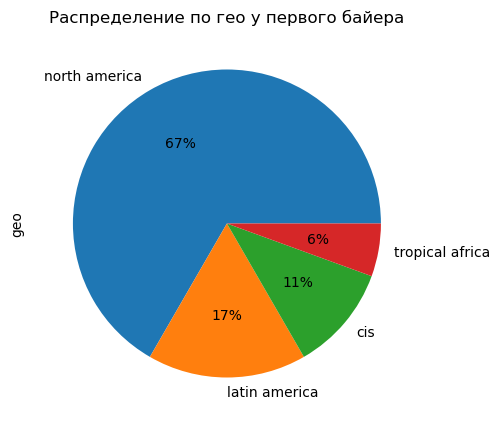

In [56]:
data_1.plot(kind='pie', y='geo', legend=False, figsize=(12,5), autopct='%.0f%%')
plt.title('Распределение по гео у первого байера')

Text(0.5, 1.0, 'Распределение по гео у второго байера')

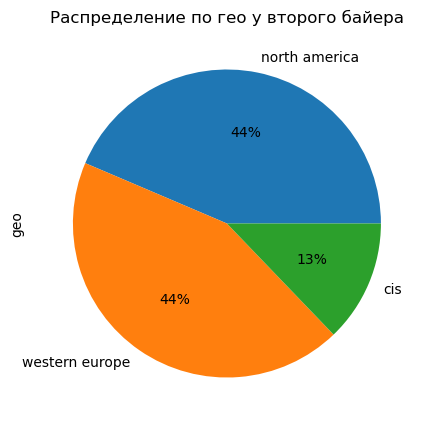

In [57]:
data_2.plot(kind='pie', y='geo', legend=False, figsize=(12,5), autopct='%.0f%%')
plt.title('Распределение по гео у второго байера')

Предположение оказалось верным: первый байер закупает рекламу на 67% в Северной Америке, в то время как у второго доля рекламы в этой локации значительно ниже - 44%, и равна доле рекламы в Восточной Европе.

### Промежуточный вывод

Расходы на рекламу у первого и второго байера очень слабо различаются. При этом эффективность у второго значительно ниже: вероятно, из-за того, что первый байер закупает рекламу преимущественно в Северной Америке, которая показала наилучшие результаты. 

# Общий вывод 


Медиабайер под номером один имеет наибольшую эффективность по всем параметрам, кроме конверсии реакций в клики - по этому параметру он на последнем месте. В остальном у него лучшие результаты. При этом расходы на его кампании равны расходам на рекламные кампании у второго байера, который имеет достаточно средние показатели. Также достаточно хорошие показатели у третьего байера, но высокая цена и за клик, и за регистрацию. 

Прибыль с одного пользователя в первый день и седьмой выше всего у третьего байера, а на тридцатый - у четвёртого. 

В распределении по геопозиции установлено, что лучше всего конвертируются пользователи из Восточной Европы, регистрируются после клика - пользователи из Латинской Америки и Северной Америки, а дешевле всего клик и установка обходятся для пользователей из Северной Африки.

Средний доход от одного пользователя выше всего и в первый, и в седьмой, и в тридцатый день выше всего в Северной Америке.

Расходы на рекламу у первого и второго байера очень слабо различаются. При этом эффективность у второго значительно ниже: вероятно, из-за того, что первый байер закупает рекламу преимущественно в Северной Америке, которая показала наилучшие результаты, а у второго доля купленной рекламы в Северной Америке и Восточной Европе почти не отличается. 